In [4]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333 and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)


100%|██████████| 10557/10557 [00:26<00:00, 396.25it/s] 


In [5]:
len(recordings)
#len(valence_values)

10391

In [6]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


(10391, (90948,))

In [ ]:
maxnsamples = 1273
valence_dict = {}

for i in valence_values:
    if i not in valence_dict:
        valence_dict[i] = 1
    else:
        valence_dict[i] += 1
oversample_quantities = {}
for key in valence_dict.keys():
    oversample_quantities[key] = 1273 - valence_dict[key]
oversample_quantities

In [8]:
def create_dict_valence_recordings(valence_values, adjusted_recordings):
    # Initialize an empty dictionary
    merged_dict = {}

    # Merge the lists into a dictionary
    for valence, recording in zip(valence_values, adjusted_recordings):
        if valence in merged_dict:
            # If the key already exists, append the recording to the list of recordings
            merged_dict[valence].append(recording)
        else:
            # If the key does not exist, create a new list with the recording
            merged_dict[valence] = [recording]
    return merged_dict

In [9]:
import random

def oversample_recordings(recordings, oversampled_recordings, num_oversamples=1):
    # Check if the recordings list is not empty
    if recordings:
        for _ in range(num_oversamples):
            # Select a random element from the recordings list
            random_recording = random.choice(recordings)
            # Append the random recording to the oversampled_recordings list
            oversampled_recordings.append(random_recording)
    return  oversampled_recordings

In [10]:
def oversample_dict(recordings_dict, oversample_quantities):
    # Initialize an empty dictionary to store oversampled recordings
    oversampled_dict = {}

    # Iterate over each valence value and oversample recordings
    for valence, quantity in oversample_quantities.items():
        if quantity > 0:
            oversampled_recordings = []
            # Get the recordings for the valence value
            recordings = merged_dict[valence]

            oversample_recordings(recordings, oversampled_recordings, num_oversamples=quantity)
            # Store the oversampled recordings in the oversampled dictionary
            oversampled_dict[valence] = oversampled_recordings
    return oversampled_dict

In [ ]:
for v in oversampled_dict.values():
    print(len(v))

In [12]:
def merge_dicts(merged_dict, oversampled_dict)    
    # Iterate over each key in oversampled_dict
    for valence, oversampled_recordings in oversampled_dict.items():
        # Check if the key already exists in merged_dict
        if valence in merged_dict:
            # If the key exists, append the oversampled recordings to the existing list
            merged_dict[valence].extend(oversampled_recordings)
        else:
            # If the key does not exist, create a new key-value pair with the oversampled recordings
            merged_dict[valence] = oversampled_recordings
    return merged_dict

17


In [14]:
def add_oversamples_to_original(merged_dict, X_train, y_train):
    X_train = []
    y_train = []

    # Iterate over each key-value pair in merged_dict
    for valence, recordings in merged_dict.items():
        # Append each recording to the X_train list
        X_train.extend(recordings)
        # Append the corresponding valence value to the y_train list
        y_train.extend([valence] * len(recordings))

    return X_train, y_train

# Print the lengths of the lists
print("Length of adjusted_recordings:", len(adjusted_recordings))
print("Length of valence_values:", len(valence_values))

Length of adjusted_recordings: 21641
Length of valence_values: 21641


In [15]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader


from sklearn.model_selection import train_test_split




############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(adjusted_recordings, valence_values, test_size=0.4, random_state=42)

# Oversample data

merged_dict = create_dict_valence_recordings(y_train, X_train)

oversampled_dict = oversample_dict(recordings_dict, oversample_quantities)

merged_dict = merge_dicts(merged_dict, oversampled_dict)


X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




C:\Users\20211922\AppData\Local\Temp\ipykernel_24284\315125929.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features


In [18]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([12984, 1, 90948]), torch.Size([12984]))

In [21]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=44100,      ## 44.1 kHz
            n_mfcc=40              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(40))
        conv1 = nn.Conv1d(in_channels=40, out_channels=20, kernel_size=10, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(20))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=2))
        self.layers.append(nn.Dropout(0.25))

        conv2 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=10, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(20))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=2))
       
        conv3 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=10, padding=1)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(10))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=2))
        self.layers.append(nn.Dropout(0.25))

        self.layers.append(nn.Flatten())

        linear1= nn.Linear(500,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
print("cuda") if torch.cuda.is_available() else print("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))


def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')

c:\Users\20211922\Documents\DeepL\DL_ASSIGNMENT\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


cuda


In [22]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
train_model(modelCNN, optimizer, num_epochs=50)

c:\Users\20211922\Documents\DeepL\DL_ASSIGNMENT\.venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
  2%|▏         | 1/50 [00:17<14:18, 17.53s/it]

Epoch [1/50], Loss: 2.7012
--------------------------------------------------


  4%|▍         | 2/50 [00:22<07:58,  9.97s/it]

Epoch [2/50], Loss: 1.2465
--------------------------------------------------
Epoch [3/50], Loss: 1.0489


  6%|▌         | 3/50 [00:32<07:45,  9.90s/it]

Mean Squared Error: 1.0525 and Mean Absolute Error: 0.8486
None
--------------------------------------------------
Epoch [4/50], Loss: 0.9444


  8%|▊         | 4/50 [00:38<06:38,  8.65s/it]

Mean Squared Error: 0.9517 and Mean Absolute Error: 0.7919
None
--------------------------------------------------
Epoch [5/50], Loss: 0.8542


 10%|█         | 5/50 [00:44<05:46,  7.71s/it]

Mean Squared Error: 0.8620 and Mean Absolute Error: 0.7646
None
--------------------------------------------------
Epoch [6/50], Loss: 0.8103


 12%|█▏        | 6/50 [00:50<05:15,  7.16s/it]

Mean Squared Error: 0.8159 and Mean Absolute Error: 0.7375
None
--------------------------------------------------
Epoch [7/50], Loss: 0.7679


 14%|█▍        | 7/50 [00:56<04:48,  6.71s/it]

Mean Squared Error: 0.7550 and Mean Absolute Error: 0.7058
None
--------------------------------------------------
Epoch [8/50], Loss: 0.7285


 16%|█▌        | 8/50 [01:02<04:27,  6.37s/it]

Mean Squared Error: 0.7364 and Mean Absolute Error: 0.7054
None
--------------------------------------------------
Epoch [9/50], Loss: 0.7056


 18%|█▊        | 9/50 [01:07<04:11,  6.14s/it]

Mean Squared Error: 0.7265 and Mean Absolute Error: 0.6928
None
--------------------------------------------------
Epoch [10/50], Loss: 0.6844


 20%|██        | 10/50 [01:13<03:59,  5.98s/it]

Mean Squared Error: 0.6981 and Mean Absolute Error: 0.6751
None
--------------------------------------------------
Epoch [11/50], Loss: 0.6664


 22%|██▏       | 11/50 [01:19<03:48,  5.86s/it]

Mean Squared Error: 0.6909 and Mean Absolute Error: 0.6746
None
--------------------------------------------------
Epoch [12/50], Loss: 0.6496


 24%|██▍       | 12/50 [01:24<03:39,  5.78s/it]

Mean Squared Error: 0.6709 and Mean Absolute Error: 0.6621
None
--------------------------------------------------
Epoch [13/50], Loss: 0.6379


 26%|██▌       | 13/50 [01:30<03:31,  5.71s/it]

Mean Squared Error: 0.6637 and Mean Absolute Error: 0.6567
None
--------------------------------------------------
Epoch [14/50], Loss: 0.6192


 28%|██▊       | 14/50 [01:36<03:25,  5.72s/it]

Mean Squared Error: 0.6466 and Mean Absolute Error: 0.6532
None
--------------------------------------------------
Epoch [15/50], Loss: 0.6156


 30%|███       | 15/50 [01:41<03:21,  5.76s/it]

Mean Squared Error: 0.6506 and Mean Absolute Error: 0.6524
None
--------------------------------------------------
Epoch [16/50], Loss: 0.6051


 32%|███▏      | 16/50 [01:48<03:20,  5.89s/it]

Mean Squared Error: 0.6242 and Mean Absolute Error: 0.6390
None
--------------------------------------------------
Epoch [17/50], Loss: 0.5916


 34%|███▍      | 17/50 [01:55<03:32,  6.44s/it]

Mean Squared Error: 0.6318 and Mean Absolute Error: 0.6394
None
--------------------------------------------------
Epoch [18/50], Loss: 0.5862


 36%|███▌      | 18/50 [02:03<03:42,  6.95s/it]

Mean Squared Error: 0.6210 and Mean Absolute Error: 0.6354
None
--------------------------------------------------
Epoch [19/50], Loss: 0.5763


 38%|███▊      | 19/50 [02:12<03:51,  7.47s/it]

Mean Squared Error: 0.6148 and Mean Absolute Error: 0.6363
None
--------------------------------------------------
Epoch [20/50], Loss: 0.5659


 40%|████      | 20/50 [02:19<03:34,  7.16s/it]

Mean Squared Error: 0.6023 and Mean Absolute Error: 0.6257
None
--------------------------------------------------
Epoch [21/50], Loss: 0.5566


 42%|████▏     | 21/50 [02:25<03:18,  6.83s/it]

Mean Squared Error: 0.6049 and Mean Absolute Error: 0.6279
None
--------------------------------------------------
Epoch [22/50], Loss: 0.5500


 44%|████▍     | 22/50 [02:30<03:01,  6.48s/it]

Mean Squared Error: 0.5952 and Mean Absolute Error: 0.6226
None
--------------------------------------------------
Epoch [23/50], Loss: 0.5492


 46%|████▌     | 23/50 [02:36<02:48,  6.24s/it]

Mean Squared Error: 0.5844 and Mean Absolute Error: 0.6191
None
--------------------------------------------------
Epoch [24/50], Loss: 0.5377


 48%|████▊     | 24/50 [02:42<02:38,  6.08s/it]

Mean Squared Error: 0.5834 and Mean Absolute Error: 0.6132
None
--------------------------------------------------
Epoch [25/50], Loss: 0.5316


 50%|█████     | 25/50 [02:47<02:28,  5.95s/it]

Mean Squared Error: 0.5764 and Mean Absolute Error: 0.6091
None
--------------------------------------------------
Epoch [26/50], Loss: 0.5259


 52%|█████▏    | 26/50 [02:53<02:20,  5.86s/it]

Mean Squared Error: 0.5659 and Mean Absolute Error: 0.6109
None
--------------------------------------------------
Epoch [27/50], Loss: 0.5235


 54%|█████▍    | 27/50 [02:59<02:13,  5.82s/it]

Mean Squared Error: 0.5636 and Mean Absolute Error: 0.6075
None
--------------------------------------------------
Epoch [28/50], Loss: 0.5165


 56%|█████▌    | 28/50 [03:04<02:06,  5.76s/it]

Mean Squared Error: 0.5653 and Mean Absolute Error: 0.6043
None
--------------------------------------------------
Epoch [29/50], Loss: 0.5086


 58%|█████▊    | 29/50 [03:10<02:00,  5.75s/it]

Mean Squared Error: 0.5682 and Mean Absolute Error: 0.6062
None
--------------------------------------------------
Epoch [30/50], Loss: 0.5106


 60%|██████    | 30/50 [03:16<01:54,  5.70s/it]

Mean Squared Error: 0.5578 and Mean Absolute Error: 0.5984
None
--------------------------------------------------
Epoch [31/50], Loss: 0.4993


 62%|██████▏   | 31/50 [03:21<01:47,  5.68s/it]

Mean Squared Error: 0.5620 and Mean Absolute Error: 0.6037
None
--------------------------------------------------
Epoch [32/50], Loss: 0.5011


 64%|██████▍   | 32/50 [03:27<01:42,  5.70s/it]

Mean Squared Error: 0.5522 and Mean Absolute Error: 0.5971
None
--------------------------------------------------
Epoch [33/50], Loss: 0.4950


 66%|██████▌   | 33/50 [03:33<01:36,  5.69s/it]

Mean Squared Error: 0.5501 and Mean Absolute Error: 0.5948
None
--------------------------------------------------
Epoch [34/50], Loss: 0.4959


 68%|██████▊   | 34/50 [03:38<01:30,  5.67s/it]

Mean Squared Error: 0.5400 and Mean Absolute Error: 0.5888
None
--------------------------------------------------
Epoch [35/50], Loss: 0.4881


 70%|███████   | 35/50 [03:44<01:24,  5.66s/it]

Mean Squared Error: 0.5389 and Mean Absolute Error: 0.5892
None
--------------------------------------------------
Epoch [36/50], Loss: 0.4858


 72%|███████▏  | 36/50 [03:50<01:18,  5.63s/it]

Mean Squared Error: 0.5316 and Mean Absolute Error: 0.5854
None
--------------------------------------------------
Epoch [37/50], Loss: 0.4758


 74%|███████▍  | 37/50 [03:55<01:13,  5.68s/it]

Mean Squared Error: 0.5359 and Mean Absolute Error: 0.5885
None
--------------------------------------------------
Epoch [38/50], Loss: 0.4787


 76%|███████▌  | 38/50 [04:01<01:08,  5.70s/it]

Mean Squared Error: 0.5284 and Mean Absolute Error: 0.5820
None
--------------------------------------------------
Epoch [39/50], Loss: 0.4746


 78%|███████▊  | 39/50 [04:07<01:02,  5.66s/it]

Mean Squared Error: 0.5294 and Mean Absolute Error: 0.5855
None
--------------------------------------------------
Epoch [40/50], Loss: 0.4656


 80%|████████  | 40/50 [04:12<00:56,  5.67s/it]

Mean Squared Error: 0.5340 and Mean Absolute Error: 0.5907
None
--------------------------------------------------


 80%|████████  | 40/50 [04:17<01:04,  6.43s/it]


KeyboardInterrupt: 

Mean Squared Error: 0.5072 and Mean Absolute Error: 0.5744


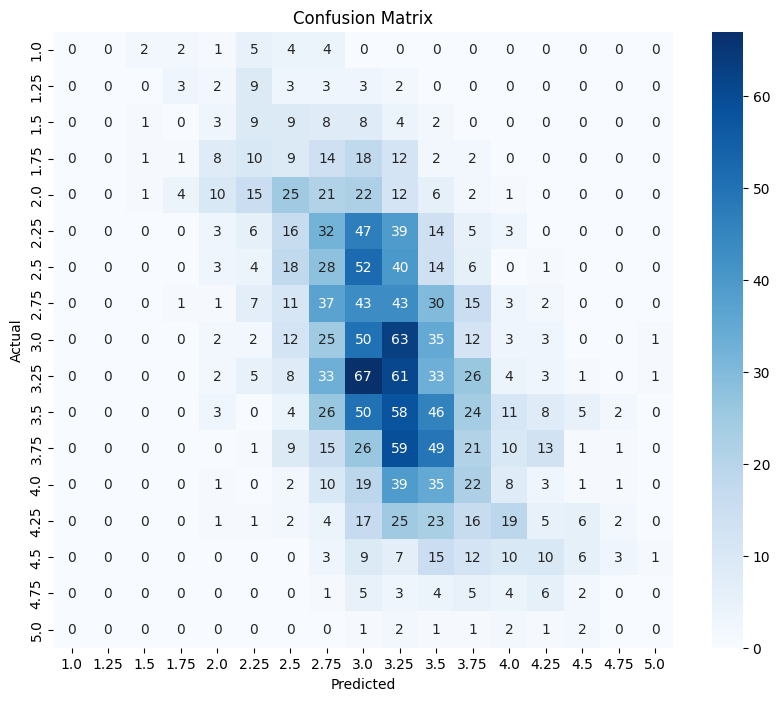

Accuracy: 0.1299


In [180]:
evaluate_model(modelCNN, test_loader,conf=True)

Mean Squared Error: 0.4162 and Mean Absolute Error: 0.5158


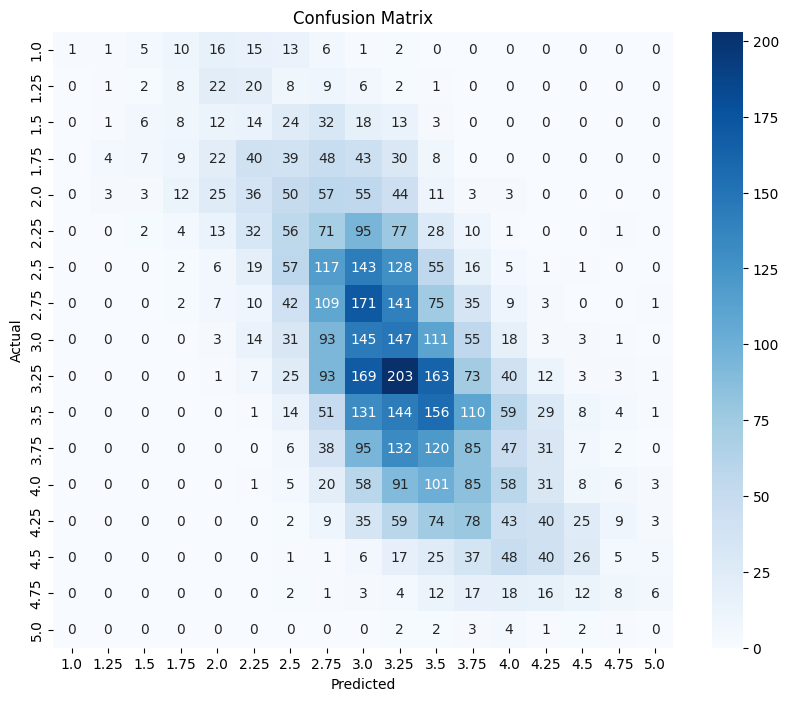

Accuracy: 0.1542


In [168]:
evaluate_model(modelCNN, train_loader,conf=True)